## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [169]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Classification
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
!pip install emoji
import emoji

In [4]:
!pip install contractions
import contractions

In [5]:
import html
import re

In [6]:
# load data
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(5000,
                                        random_state = 42)

/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_5610/867448663.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")


In [7]:
pd.options.display.max_colwidth = None
print(congress_tweets['text'][:10])

445325                                                                                                                                                                                                                                                                                                                 I introduced the Main Street Growth Act to get more companies to go public and allow everyone to share in America’s booming markets. You can read more about my bill here https://emmer.house.gov/press-releases?ContentRecord_id=53235569-51F9-4892-93D1-C6E2D56932B9  #NatlEshipWeek
48352                                                                                                                                                                                                                                                                                             Pleased I was able to meet with @uapbchancellor Dr. Laurence Alexander today about what’s happening on the campus of UAP

Tweet data includes **(1) URLs, mentions, retweets (RTs), quote tweets(QT), and hashtags; (2) Formatting markers such as “&amp” and “\n \n”; (3) Emojis and informal expressions (e.g., “w/”).**  
Beside applying the standard text preprocessing, I will first clean the tweet data. Specifically, I will remove all URLs, mentions, RTs, and formatting markers. However, since hashtags may contain valuable information, I will strip the “#” symbol while retaining the words within the hashtags. I will expand contractions and convert emojis into their corresponding text descriptions to enhance text clarity.

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
congress_tweets = congress_tweets.reset_index(drop=True)

In [9]:
# Special Cases on Party Membership
# two independent Senators - treat as Democratic Party
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Bernie Sanders', 'party'] = 'Democrat'
congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Angus King', 'party'] = 'Democrat'

# three party switches - drop
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Justin Amash'].index)
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Paul Mitchell'].index)
congress_tweets = congress_tweets.drop(congress_tweets[congress_tweets['name_wikipedia'] == 'Jeff Van Drew'].index)

For special cases regarding party membership:

**Two independent senators:** Since senators are already a minority group, we want to avoid losing samples. Given that these two senators caucus with the Democratic Party, it is reasonable to assume that their political stance is similar to that of the Democrats. Therefore, I classify their party as the Democratic Party.

**Three party switchers:** Party switching is an unusual occurrence. Short-term party changes may be driven by political opportunism, so I remove these data points. However, if there were a large number of records related to party switching, they could actually serve as evidence for identifying party affiliation and tweet patterns.

In [10]:
# convert emojis
congress_tweets['text'] = congress_tweets['text'].apply(lambda x: emoji.demojize(x, delimiters=(' ', ' ')))

In [11]:
# expand contractions and "w/"
def normalize_text(text):
    text = re.sub(r"[‘’`]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"\bw/\b", "with", text)
    return text

congress_tweets['text'] = congress_tweets['text'].apply(lambda x: contractions.fix(normalize_text(x)))

In [12]:
print(congress_tweets['text'][:10])

0                                                                                                                                                                                                                                                                                                                   I introduced the Main Street Growth Act to get more companies to go public and allow everyone to share in America's booming markets. You can read more about my bill here https://emmer.house.gov/press-releases?ContentRecord_id=53235569-51F9-4892-93D1-C6E2D56932B9  #NatlEshipWeek
1                                                                                                                                                                                                                                                                                             Pleased I was able to meet with @uapbchancellor Dr. Laurence Alexander today about what is happening on the campus of UAPB and 

In [112]:
def rem_punc_stop(text):

    #handle html entities
    text = html.unescape(text)

    #remove "\n\n"
    text = text.replace("\n", " ").replace("\r", " ")

    stop_words = STOP_WORDS

    #remove retweet
    nlp.Defaults.stop_words.update({'rt','qt'})

    #remove punctuation
    punc = set(punctuation)
    punc.discard('@')
    punc_free = "".join([ch for ch in text if ch not in punc])

    #lowercasing & tokenization
    doc = nlp(punc_free.lower())

    spacy_words = []
    skip_next = False
    for token in doc:
        word = token.text
        #remove URLs, mentions, and "#" for hashtags
        if word.startswith('http'):
            continue
        if word.startswith('@'):
            skip_next = True
            continue
        if skip_next and token.is_alpha:
            skip_next = False
            continue
        if word == ' ':
            continue
        spacy_words.append(word)

    no_punc = [word for word in spacy_words if word not in stop_words]
    cleaned_tokens = [word for word in spacy_words if len(word) > 1 and word.isalpha() and word.lower() not in stop_words]

    return cleaned_tokens

In [113]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x:rem_punc_stop(x))
congress_tweets['tokens']

0                                                                                                                                                              [introduced, main, street, growth, act, companies, public, allow, share, americas, booming, markets, read, bill, natleshipweek]
1                                                                                                             [pleased, able, meet, laurence, alexander, today, happening, campus, uapb, better, strengthen, assist, hbcus, minorityserving, institutions, including, supporting, future, act]
2       [del, en, california, smallbluediamond, casos, confirmados, hasta, el, día, de, hoy, smallbluediamond, nota, es, posible, que, los, números, representen, los, cambios, verdaderos, de, un, día, otro, ya, que, el, informe, de, los, resultados, de, las, pruebas, puede, retrasarse]
3                                                                                                                                          

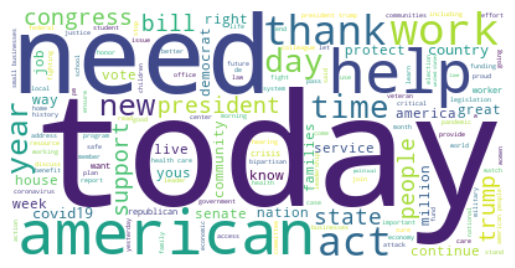

In [15]:
# use wordcloud to check preprocessing quality
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

wordcloud = WordCloud(background_color = 'white',             # set background color to white
                      random_state=42  # set random state to ensure same word cloud each time
                      ).generate(text)           # change the background color


# plot
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools.

### EDA 1: Lengths and Counts

In [18]:
congress_tweets['length'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

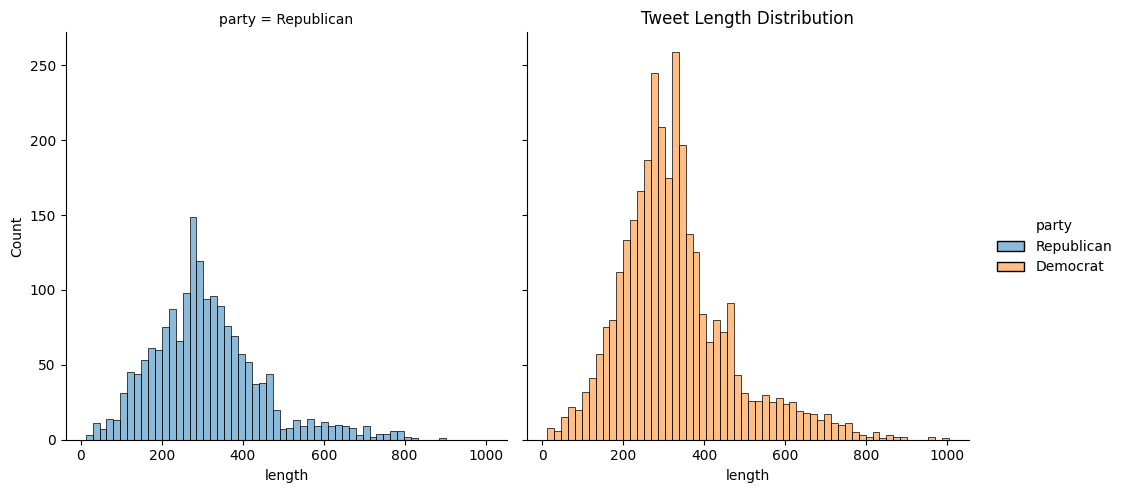

In [19]:
sns.displot(data = congress_tweets,
            x = 'length',
            hue = 'party',
            col = 'party')
plt.title('Tweet Length Distribution')
plt.show()

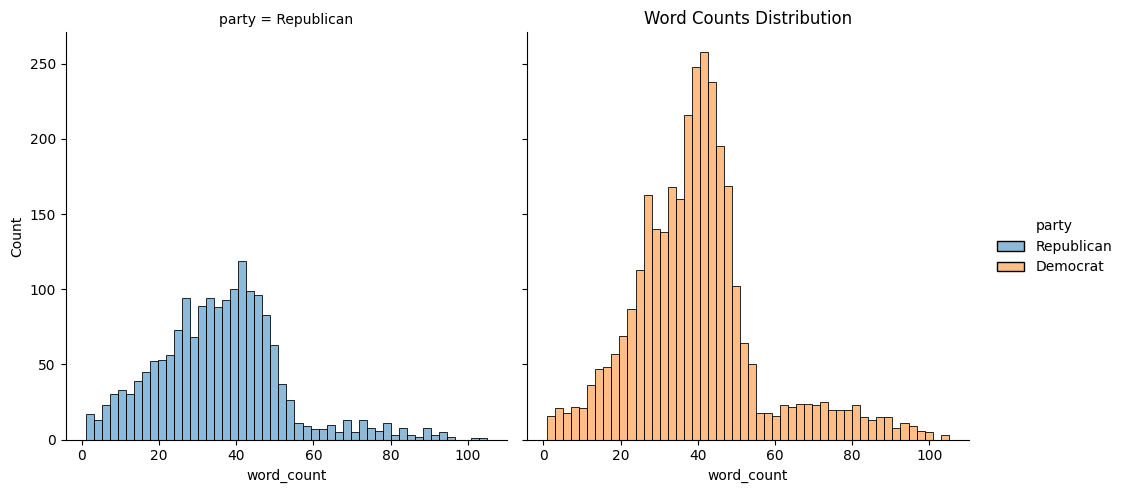

In [20]:
sns.displot(data = congress_tweets,
            x = 'word_count',
            hue = 'party',
            col = 'party')
plt.title('Word Counts Distribution')
plt.show()

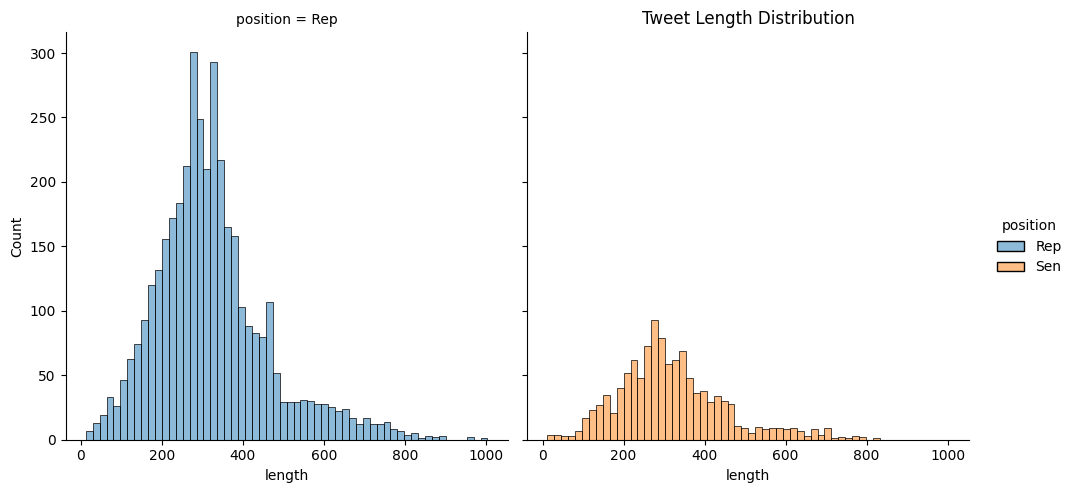

In [21]:
sns.displot(data = congress_tweets,
            x = 'length',
            hue = 'position',
            col = 'position')
plt.title('Tweet Length Distribution')
plt.show()

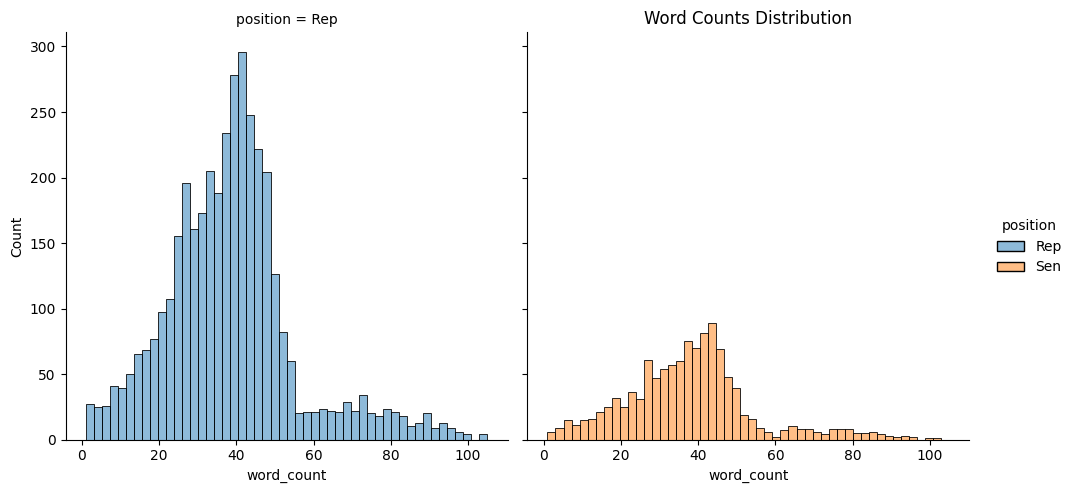

In [22]:
sns.displot(data = congress_tweets,
            x = 'word_count',
            hue = 'position',
            col = 'position')
plt.title('Word Counts Distribution')
plt.show()

In [23]:
summary_length = congress_tweets.groupby('party')['length'].describe()
summary_length = pd.concat([summary_length, congress_tweets.groupby('position')['length'].describe()])
summary_length

,count,mean,std,min,25%,50%,75%,max
Democrat,3240.0,328.232407,138.961955,12.0,240.75,309.0,386.0,1004.0
Republican,1754.0,311.195553,136.851433,22.0,222.00,294.0,378.0,895.0
Rep,3851.0,323.294469,139.821515,12.0,236.00,305.0,381.5,1004.0
Sen,1143.0,318.725284,133.724046,19.0,230.00,297.0,386.0,826.0


In [24]:
summary_word_count = congress_tweets.groupby('party')['word_count'].describe()
summary_word_count = pd.concat([summary_word_count, congress_tweets.groupby('position')['word_count'].describe()])
summary_word_count

,count,mean,std,min,25%,50%,75%,max
Democrat,3240.0,39.794444,16.794649,1.0,30.0,39.0,46.0,105.0
Republican,1754.0,35.902509,16.555846,1.0,25.0,36.0,45.0,105.0
Rep,3851.0,38.597767,16.838653,1.0,28.0,38.0,46.0,105.0
Sen,1143.0,37.853893,16.718610,1.0,28.0,38.0,45.0,102.0


Democratic tweets tend to be longer and more detailed, with an average of 39.79 words vs. 35.90 and 328.23 characters vs. 311.19 compared to Republican tweets.Republican tweets are generally shorter and more varied in length, with a higher frequency of very short tweets.

House Representatives (Rep) tend to write longer and more variable tweets, with the longest reaching 1,004 characters. Senators (Sen) have more consistent tweet lengths.

Democrats tend to provide more detailed expressions, while Republicans favor shorter, more impactful communication. This suggests a difference in stylistic approach between the two parties. House representatives show more flexibility in their tweets, whereas senators maintain a relatively uniform style.

### EDA 2: WordCloud and Topic Modeling

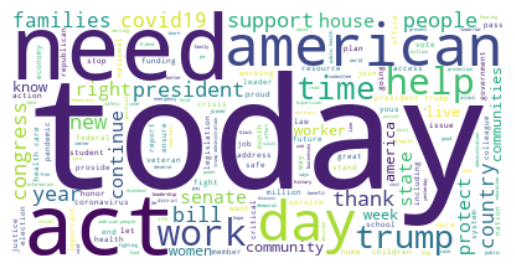

In [25]:
dem_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
rep_tweets = congress_tweets[congress_tweets['party'] == 'Republican']

dem_text = ' '.join(dem_tweets['tokens'].map(lambda text: ' '.join(text)))
rep_text = ' '.join(rep_tweets['tokens'].map(lambda text: ' '.join(text)))

dem_wordcloud = WordCloud(background_color = 'white',
                      random_state=42
                      ).generate(dem_text)

rep_wordcloud = WordCloud(background_color = 'white',
                      random_state=42
                      ).generate(rep_text)


# plot
plt.imshow(dem_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

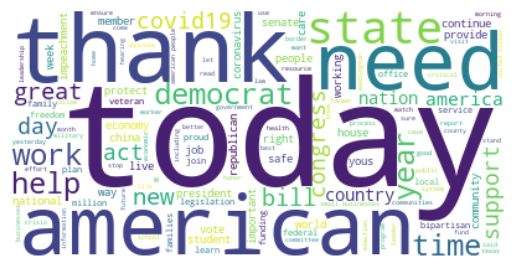

In [26]:
plt.imshow(rep_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [116]:
tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None)
tfidf_matrix = tf.fit_transform(congress_tweets['tokens'].str.join(' '))
dense_matrix = tfidf_matrix.todense()

In [118]:
lda = LatentDirichletAllocation(n_components = 5,
                                max_iter = 20,
                                random_state = 42)
lda = lda.fit(np.asarray(dense_matrix))

In [119]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [233]:
tf_feature_names = tf.get_feature_names_out()

print_top_words(lda,
                tf_feature_names,
                20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

topic_dist_df


Topic #0:
nurses statement tune doctors transcript backhandindexpointingdown refugees daca floyd joining fort read purpose collins explanation hong justiceact offered radio kong

Topic #1:
today people act need trump house health president work time help congress american bill americans support care new senate day

Topic #2:
telephone king congratulations happy socialism game jr grand practice birthday wish loss monitoring participating pt luther hall best martin celebrating

Topic #3:
de en la wishing los que el para del happy las advocacy newsletter love vietnam soil se pfas corner merry

Topic #4:
schiff adam knows hunt witch sham summer section fisa dear spot charge compelling overwhelming chibokgirls americafirst miami rice stopped species



,0,1,2,3,4
0,0.042028,0.831978,0.041997,0.041998,0.041999
1,0.274176,0.610386,0.038366,0.038367,0.038705
2,0.033544,0.034121,0.033545,0.865230,0.033560
3,0.043406,0.826358,0.043404,0.043420,0.043412
4,0.044224,0.657536,0.044458,0.044222,0.209560
...,...,...,...,...,...
4989,0.043070,0.827726,0.043077,0.043064,0.043063
4990,0.042472,0.830106,0.042479,0.042472,0.042472
4991,0.041768,0.640532,0.234130,0.041825,0.041746
4992,0.041937,0.832250,0.041937,0.041938,0.041938


In [234]:
party_topic_dist = topic_dist_df.groupby(congress_tweets['party']).mean()
print(party_topic_dist) 

                   0         1         2         3         4
party                                                       
Democrat    0.080761  0.696382  0.078976  0.073112  0.070769
Republican  0.078244  0.693459  0.081761  0.071402  0.075134


In [235]:
party_topic_dist = topic_dist_df.groupby(congress_tweets['position']).mean()
print(party_topic_dist) 

                 0         1         2         3        4
position                                                 
Rep       0.079734  0.697502  0.078876  0.071498  0.07239
Sen       0.080355  0.688126  0.083585  0.075924  0.07201


Wordclouds seem to provide limited actionable insights, whereas topic modeling results are likely to be more interpretable:
**Topic #0:** Covers healthcare, social justice, immigration, and international affairs.
**Topic #1:** Focuses on government actions, legislation, the president, and policymaking.
**Topic #2:** Relates to commemorations, historical figures, and cultural celebrations, such as mentions of "King, Luther" (Ideally they should be treated as one token?).
**Topic #3:** Likely associated with Spanish-language tweets, potentially related to Latino voters and immigration issues.
**Topic #4:** Involves political investigations, FISA, government surveillance, and partisan conflicts.

Republicans are more likely to mention Topic #2 (commemorations) and Topic #4 (political investigations), with a particularly strong emphasis on Topic #4. Democrats are more likely to discuss Topic #3 (Spanish-language content, Latino voters, and immigration issues). 
Senators mention Topic #2 (commemorations) and Topic #3 (Spanish-language content) more frequently. For other topics, there is little difference between senators and house representatives.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives

`TextBlob` has already been imported in the top cell.

### TextBlob

In [31]:
congress_tweets['polarity'] = congress_tweets['tokens'].str.join(' ').map(lambda t: TextBlob(t).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].str.join(' ').map(lambda t: TextBlob(t).sentiment.subjectivity)

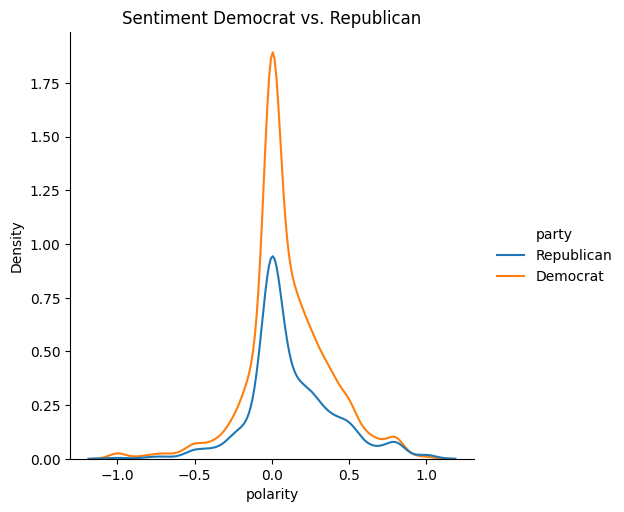

In [32]:
sns.displot(data = congress_tweets,
            x = 'polarity',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

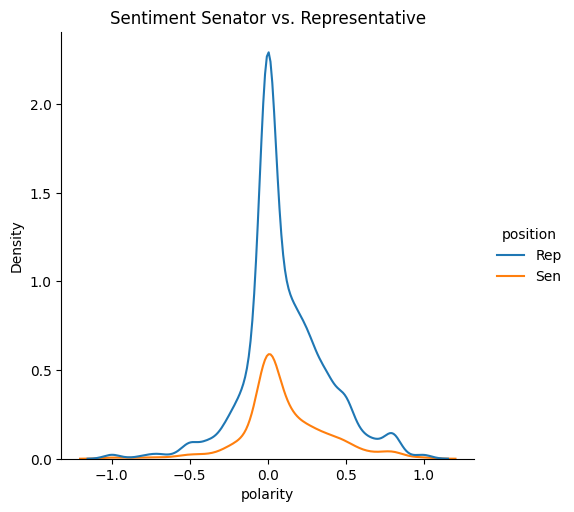

In [33]:
sns.displot(data = congress_tweets,
            x = 'polarity',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

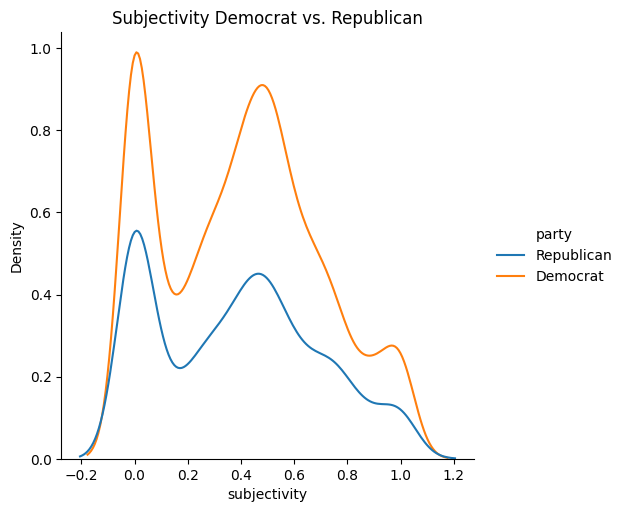

In [34]:
sns.displot(data = congress_tweets,
            x = 'subjectivity',
            hue = 'party',
            kind = 'kde')
plt.title('Subjectivity Democrat vs. Republican')
plt.show()

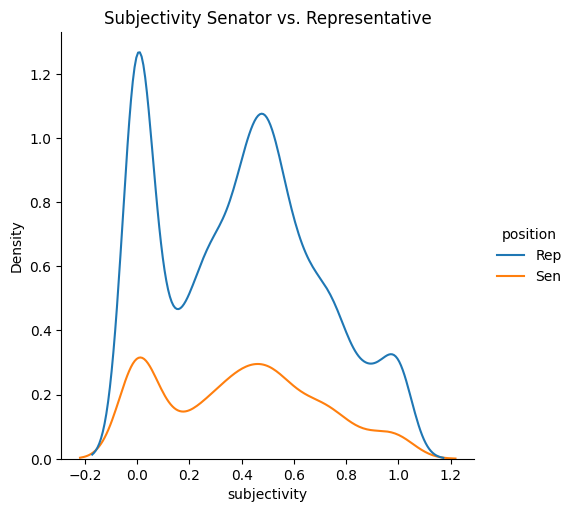

In [35]:
sns.displot(data = congress_tweets,
            x = 'subjectivity',
            hue = 'position',
            kind = 'kde')
plt.title('Subjectivity Senator vs. Representative')
plt.show()

### VEDAR

In [36]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

407.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [37]:
vader_analyzer = SentimentIntensityAnalyzer()
congress_tweets['vader_scores'] = congress_tweets['text'].map(lambda t: vader_analyzer.polarity_scores(t))

In [38]:
congress_tweets['vader_scores_compound'] = congress_tweets['vader_scores'].map(lambda t: t['compound'])
congress_tweets['vader_scores_pos'] = congress_tweets['vader_scores'].map(lambda t: t['pos'])
congress_tweets['vader_scores_neu'] = congress_tweets['vader_scores'].map(lambda t: t['neu'])
congress_tweets['vader_scores_neg'] = congress_tweets['vader_scores'].map(lambda t: t['neg'])

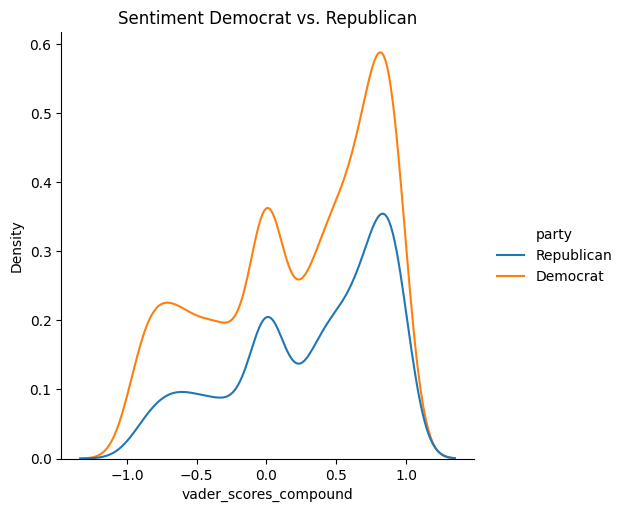

In [39]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_compound',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

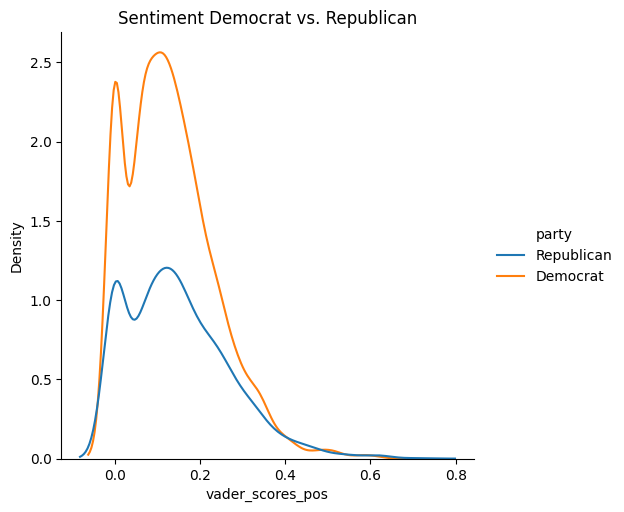

In [40]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_pos',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

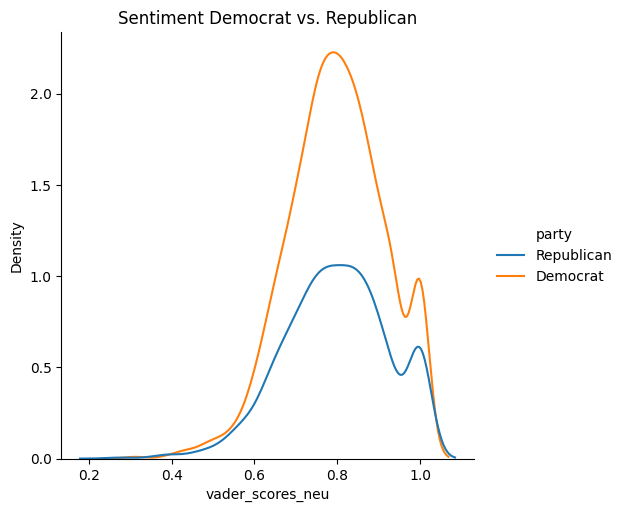

In [41]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neu',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

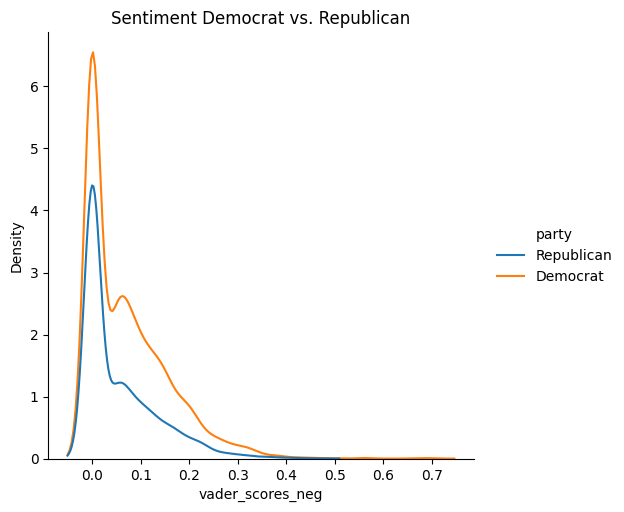

In [42]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neg',
            hue = 'party',
            kind = 'kde')
plt.title('Sentiment Democrat vs. Republican')
plt.show()

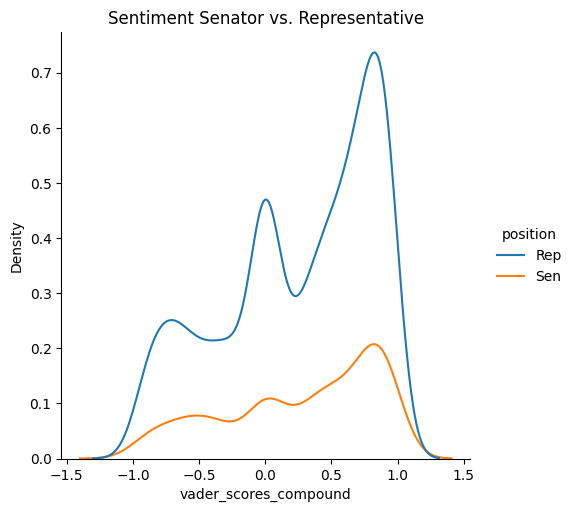

In [43]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_compound',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

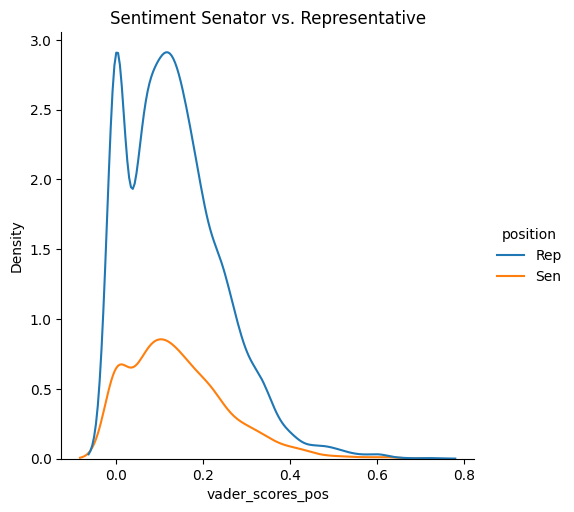

In [44]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_pos',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

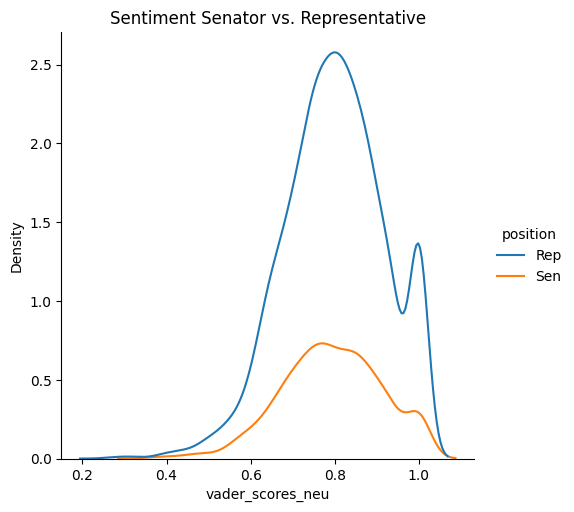

In [45]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neu',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

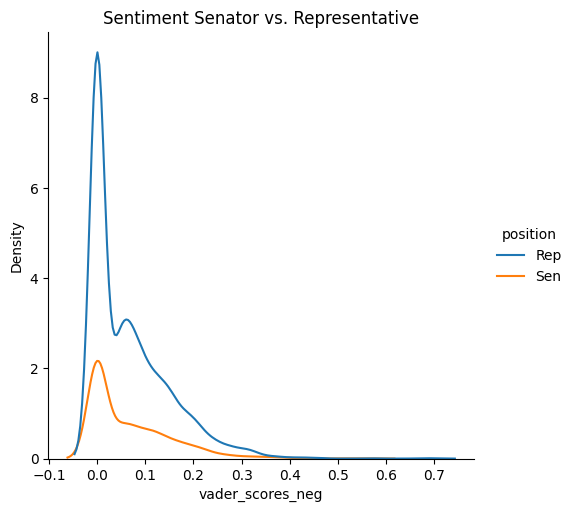

In [46]:
sns.displot(data = congress_tweets,
            x = 'vader_scores_neg',
            hue = 'position',
            kind = 'kde')
plt.title('Sentiment Senator vs. Representative')
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix.
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [47]:
# Engineered Features
engineered_features = congress_tweets[['word_count',
                                       'length',
                                       'polarity',
                                       'subjectivity',
                                       'vader_scores_compound',
                                       'vader_scores_pos',
                                       'vader_scores_neu',
                                       'vader_scores_neg']]

In [48]:
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

### Bag-of-words or Tf-idf

In [121]:
# Frequency Based featurization
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),
                        columns = tf.get_feature_names_out())

In [122]:
tfidf_df.columns

Index(['aapi', 'aapiheritagemonth', 'aaron', 'aba', 'aback', 'abandon',
       'abandoned', 'abandoning', 'abandons', 'abbott',
       ...
       '𝐰𝐚𝐲', '𝐲𝐨𝐮', '𝐴𝑐𝑡', '𝐶𝐴𝑅𝐸𝑆', '𝗖𝗜𝗡𝗖𝗜𝗡𝗡𝗔𝗧𝗜', '𝗗𝗲𝗺𝗼𝗰𝗿𝗮𝘁𝘀', '𝗮𝗿𝗲',
       '𝗱𝗲𝗹𝗮𝘆𝗶𝗻𝗴', '𝙀𝙉𝙀𝙍𝙂𝙔', '𝙂𝘼𝙈𝙀𝘿𝘼𝙔'],
      dtype='object', length=14197)

### Word Embedding

In [50]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [51]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

own_corpus = congress_tweets['tokens'].dropna().tolist()
own_corpus = [tokens for tokens in own_corpus if isinstance(tokens, list) and len(tokens) > 0]  

# 初始化 Word2Vec
word2vec_model = gensim.models.Word2Vec(vector_size=300, window=5, min_count=1, workers=-1)

# 构建词汇表
word2vec_model.build_vocab(own_corpus)
print("Word2Vec vocabulary size:", len(word2vec_model.wv))  # 确保 >1

# 替换预训练词向量
common_words = list(set(word2vec_model.wv.index_to_key) & set(model.index_to_key))
vectors_to_add = np.array([model[word] for word in common_words])

word2vec_model.wv.add_vectors(common_words, vectors_to_add)

# 训练
word2vec_model.train(own_corpus, total_examples=len(own_corpus), epochs=5, compute_loss=True)

Word2Vec vocabulary size: 15495


(0, 0)

In [52]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.key_to_index]  
    return np.mean([word2vec_model.get_vector(word) for word in doc], axis=0) if doc else np.zeros(word2vec_model.vector_size)

In [53]:
empty_list_embeddings_means = []

for doc in congress_tweets['tokens']:
    empty_list_embeddings_means.append(document_vector(model, doc))

doc_average_embeddings = np.array(empty_list_embeddings_means)

In [54]:
# embedding based featurization
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc.
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics.

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Predict Party Membership

In [55]:
print(congress_tweets['party'].value_counts(normalize=True))

party
Democrat      0.648779
Republican    0.351221
Name: proportion, dtype: float64


In [171]:
X = congress_tweets['tokens']
y_party = congress_tweets['party']

### Train Six Models with Just Text

In [172]:
dataframes = [engineered_features_with_topics,
              tfidf_df, 
              word2vec_features_df]


featurization_technique = ['Engineered Features + Topic Model',
                           'Tf-idf Features',
                           'Word Embedding Features']

In [173]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_party) 
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Democrat': 0, 'Republican': 1}


In [ ]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y_party,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=.20, 
                                                        stratify=  y_party, # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    
   
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))

    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Democrat", "Republican"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

### Predict Partisanship 

In [126]:
print(congress_tweets['position'].value_counts(normalize=True))

position
Rep    0.771125
Sen    0.228875
Name: proportion, dtype: float64


In [127]:
X = pd.DataFrame (congress_tweets['tokens'])
y_position = congress_tweets['position'].values.ravel()

In [128]:
y_encoded = le.fit_transform(y_position) 
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Rep': 0, 'Sen': 1}


Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.69      0.60      0.64       648
  Republican       0.40      0.50      0.45       351

    accuracy                           0.56       999
   macro avg       0.55      0.55      0.54       999
weighted avg       0.59      0.56      0.57       999



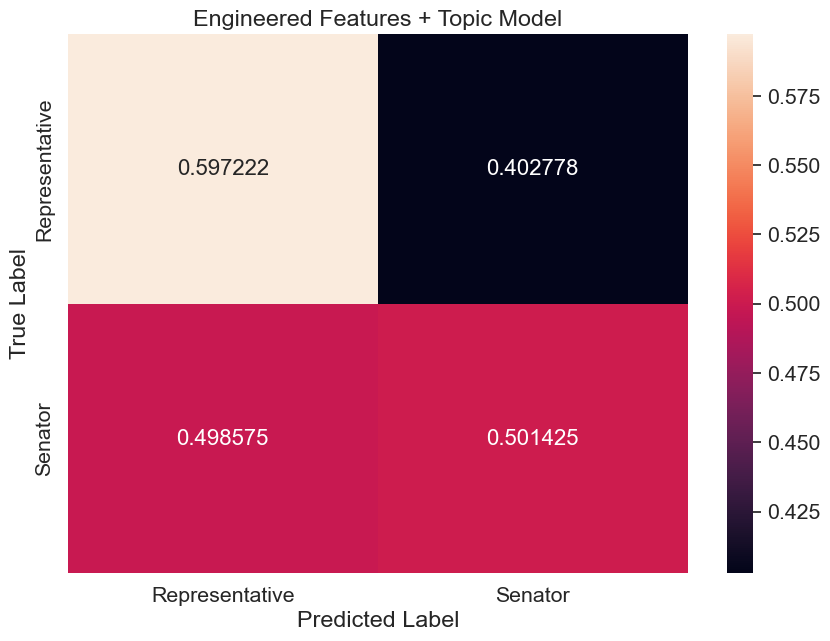

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.78      0.76      0.77       648
  Republican       0.58      0.62      0.60       351

    accuracy                           0.71       999
   macro avg       0.68      0.69      0.68       999
weighted avg       0.71      0.71      0.71       999



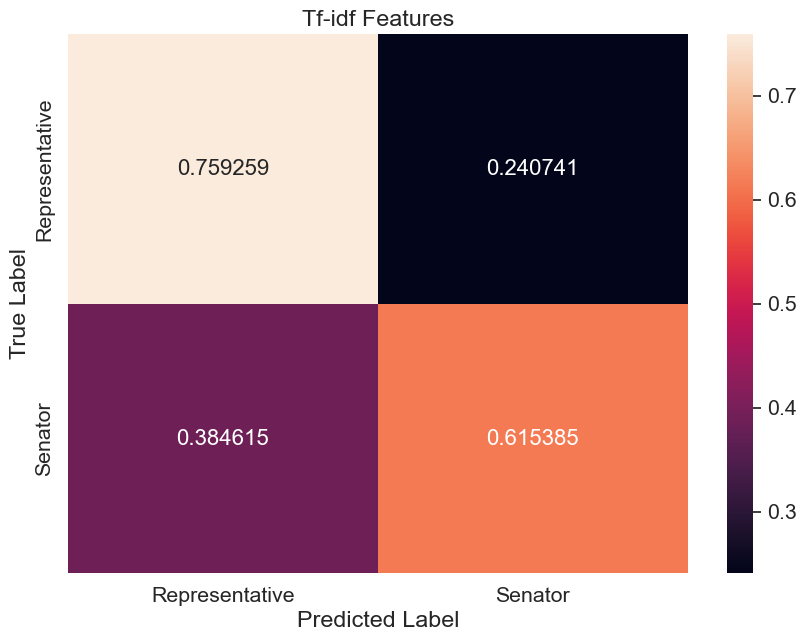

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.77      0.68      0.72       648
  Republican       0.51      0.62      0.56       351

    accuracy                           0.66       999
   macro avg       0.64      0.65      0.64       999
weighted avg       0.68      0.66      0.67       999



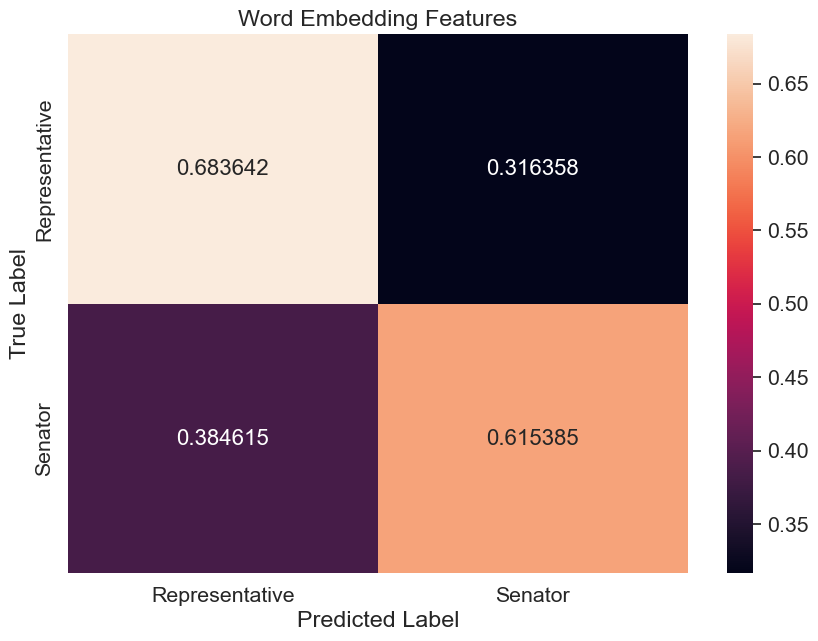

In [149]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 

    X_train, X_test, y_train, y_test = train_test_split(dataframe,         
                                                        y_position,                
                                                        train_size = .80,  
                                                        test_size=.20,
                                                        stratify=y_position, 
                                                        random_state = 10) 
    
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y_party,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=.20, 
                                                        stratify=  y_party, # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Representative", 
                                  1: "Senator"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Representative", "Senator"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [64]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length', 'word_count', 'polarity',
       'subjectivity', 'vader_scores', 'vader_scores_compound',
       'vader_scores_pos', 'vader_scores_neu', 'vader_scores_neg'],
      dtype='object')

### Predict Party Membership with Non-text Features

In [208]:
non_text_features = congress_tweets[['joined_congress_date',
                                     'birthday',
                                     'gender',
                                     'state',
                                     'trump_2016_state_share',
                                     'clinton_2016_state_share',
                                     'obama_2012_state_share',
                                     'romney_2012_state_share']]
non_text_features.head()

,joined_congress_date,birthday,gender,state,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,3-Jan-15,3/3/1961,M,MN,"1,322,951","1,367,716","1,546,167","1,320,225"
1,3-Jan-11,12/10/1950,M,AR,"684,872","380,494","394,409","647,744"
2,3-Jan-03,1/28/1969,F,CA,"4,483,814","8,753,792","7,854,285","4,839,958"
3,3-Jan-17,11/23/1950,M,NY,"2,819,533","4,556,118","4,485,741","2,490,431"
4,3-Jan-13,9/16/1974,M,TX,"4,685,047","3,877,868","3,308,124","4,569,843"


In [209]:
non_text_features['joined_congress_date'] = pd.to_datetime(non_text_features['joined_congress_date'], format='%d-%b-%y', errors='coerce')
non_text_features['days_since_joined'] = (pd.Timestamp.today() - non_text_features['joined_congress_date']).dt.days
non_text_features['birthday'] = pd.to_datetime(non_text_features['birthday'], format='%m/%d/%Y', errors='coerce')
non_text_features['age'] = (pd.Timestamp.today() - non_text_features['birthday']).dt.days // 365
non_text_features['gender'] = non_text_features['gender'].map({'M': 0, 'F': 1})
non_text_features = non_text_features.drop(columns=['joined_congress_date', 'birthday'])
for col in ['trump_2016_state_share', 'clinton_2016_state_share', 
            'obama_2012_state_share', 'romney_2012_state_share']:
    non_text_features[col] = non_text_features[col].astype(str).str.replace(',', '').astype(float)

/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_5610/2269212510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features['joined_congress_date'] = pd.to_datetime(non_text_features['joined_congress_date'], format='%d-%b-%y', errors='coerce')
/var/folders/f5/cxwzf1714jl8np8by14r5y8m0000gn/T/ipykernel_5610/2269212510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_text_features['days_since_joined'] = (pd.Timestamp.today() - non_text_features['joined_congress_date']).dt.days
/var

In [210]:
non_text_features= pd.get_dummies(non_text_features, columns=['state'], drop_first=True)

In [211]:
best_features4party = non_text_features.reset_index(drop = True).join(tfidf_df, rsuffix='_tfidf')


In [212]:
dataframes = [non_text_features,
              best_features4party]


featurization_technique = ['Non Text Features',
                           'Tf-idf Features+ Non Text Features']

Best hyperparameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.94      0.87      0.90       648
  Republican       0.79      0.89      0.84       351

    accuracy                           0.88       999
   macro avg       0.86      0.88      0.87       999
weighted avg       0.88      0.88      0.88       999



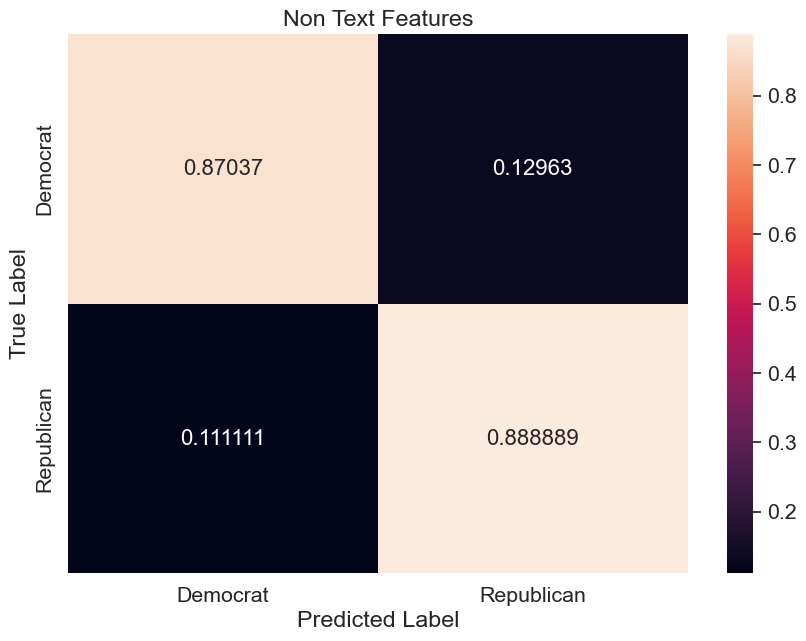

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

    Democrat       0.95      0.87      0.90       648
  Republican       0.79      0.91      0.84       351

    accuracy                           0.88       999
   macro avg       0.87      0.89      0.87       999
weighted avg       0.89      0.88      0.88       999



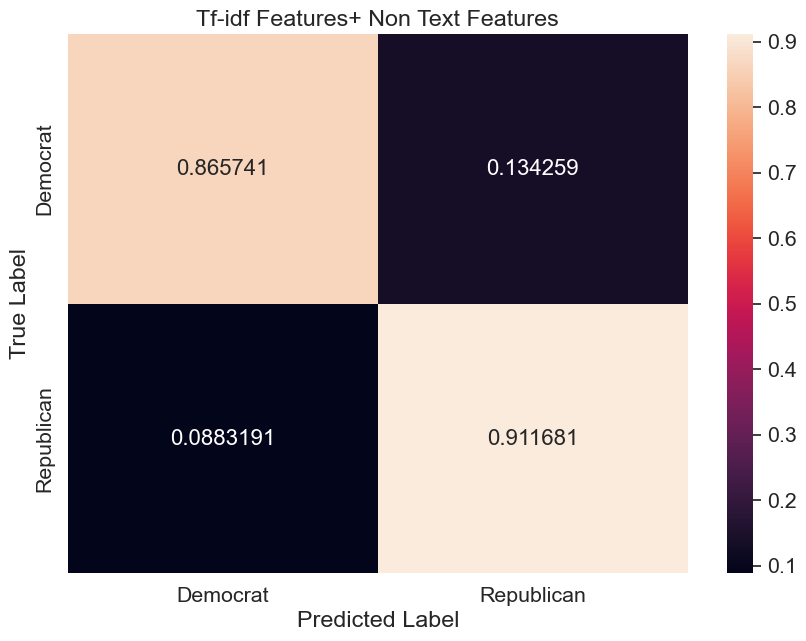

In [213]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 
    
    # split data
    # ----------
    X_train, X_test, y_train, y_test = train_test_split(dataframe,         # specify features
                                                        y_party,                 # specify labels
                                                        train_size = .80,  # specify train split of 80%
                                                        test_size=.20, 
                                                        stratify=  y_party, # specify test split of 20%
                                                        random_state = 10) # set seed for reproducibility
    
   
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))

    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Democrat", 
                                  1: "Republican"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Democrat", "Republican"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [133]:
### Predict Partisanship with Non-text Features

In [217]:
best_features4position = non_text_features.reset_index(drop = True).join(tfidf_df, rsuffix='_tfidf')

In [218]:
dataframes = [non_text_features,
              best_features4position]


featurization_technique = ['Non Text Features',
                           'Tf-idf Features+ Non Text Features']

0.06s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.90      0.74      0.81       770
         Sen       0.45      0.73      0.56       229

    accuracy                           0.74       999
   macro avg       0.68      0.73      0.69       999
weighted avg       0.80      0.74      0.75       999



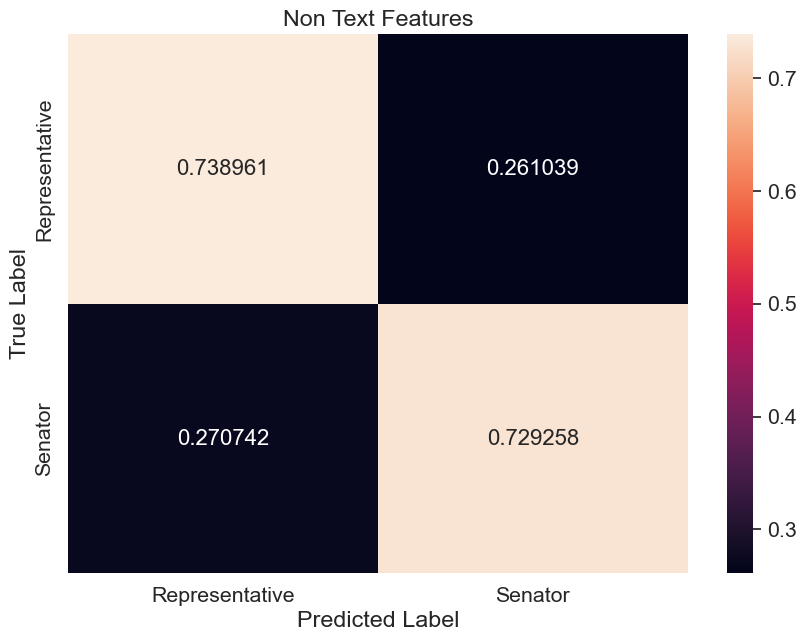

Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         Rep       0.88      0.86      0.87       770
         Sen       0.57      0.60      0.58       229

    accuracy                           0.80       999
   macro avg       0.72      0.73      0.73       999
weighted avg       0.81      0.80      0.81       999



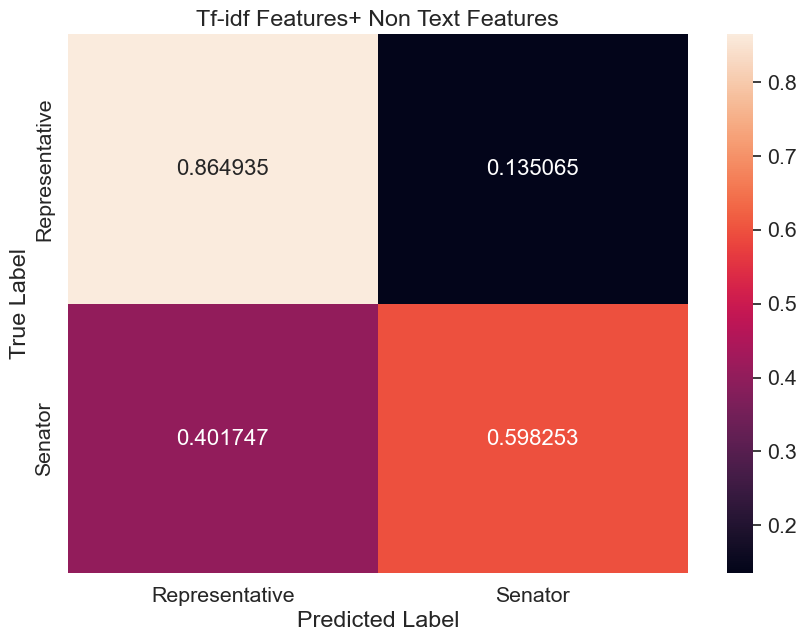

In [220]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    
    dataframe.columns = dataframe.columns.astype(str) 

    X_train, X_test, y_train, y_test = train_test_split(dataframe,         
                                                        y_position,                
                                                        train_size = .80,  
                                                        test_size=.20,
                                                        stratify=y_position, 
                                                        random_state = 10) 
    
    
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],  
        'penalty': ['l1', 'l2'],  
        'solver': ['liblinear']  }
    
    logit_reg = LogisticRegression(class_weight='balanced', max_iter=500)
    grid_search = GridSearchCV(logit_reg,
                                param_grid, 
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)


    print("Best hyperparameters:", grid_search.best_params_)
    print(classification_report( y_test, y_pred))
    
    # create a confusion matrix
    # ----------
    cf_matrix = confusion_matrix(y_test,             # specify test
                                 y_pred,             # specify predicted
                                 normalize = "true") # normalize

    # create a pandas dataframe from the confusion matrix for visualization 
    df_cm = pd.DataFrame(cf_matrix,          # specify cf_matrix from which to create dataframe 
                         range(2), range(2)) # set 2 by 2 

    # set confusion matrix indices for clarity of visualization
    df_cm = df_cm.rename(index=str, 
                         columns={0: "Representative", 
                                  1: "Senator"})

    # specify confusion matrix index for clarity
    df_cm.index = ["Representative", "Senator"]
    
    # figure specifications 
    plt.figure(figsize = (10,7)) # set figure size specifications
    sns.set(font_scale=1.4)      # set label size
    sns.heatmap(df_cm,           # specify dataset
                annot=True,    
                annot_kws={"size": 16},
                fmt='g')
    
    # figure labels
    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...